# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on iron XPS spectra made up of linear combinations of single iron reference spectra.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/app')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install packages and import modules

In [2]:
# Install packages
!pip install talos
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib
import talos

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

Using TensorFlow backend.


### Load custom modules

In [3]:
try:
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure



In [4]:
np.random.seed(502)
time = '20200908_14h21m' #datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Fe_multiple_4_classes_variable_linear_comb_Mark_gas_phase'
label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = classifier.ClassifierMultiple(time = time,
                                    data_name = data_name,
                                    labels = label_values)

Model folder was already at /saved_models/20200908_14h21m_Fe_multiple_4_classes_variable_linear_comb_Mark_gas_phase
Logs folder was already at /logs/20200908_14h21m_Fe_multiple_4_classes_variable_linear_comb_Mark_gas_phase
Figures folder was already at /figures/20200908_14h21m_Fe_multiple_4_classes_variable_linear_comb_Mark_gas_phase


### Load and inspect the data

Data was loaded!
Total no. of samples: 1000
No. of training samples: 640
No. of validation samples: 160
No. of test samples: 200
Shape of each sample : 1121 features (X) + 4 labels (y)


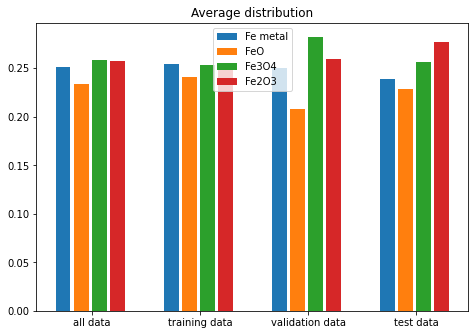

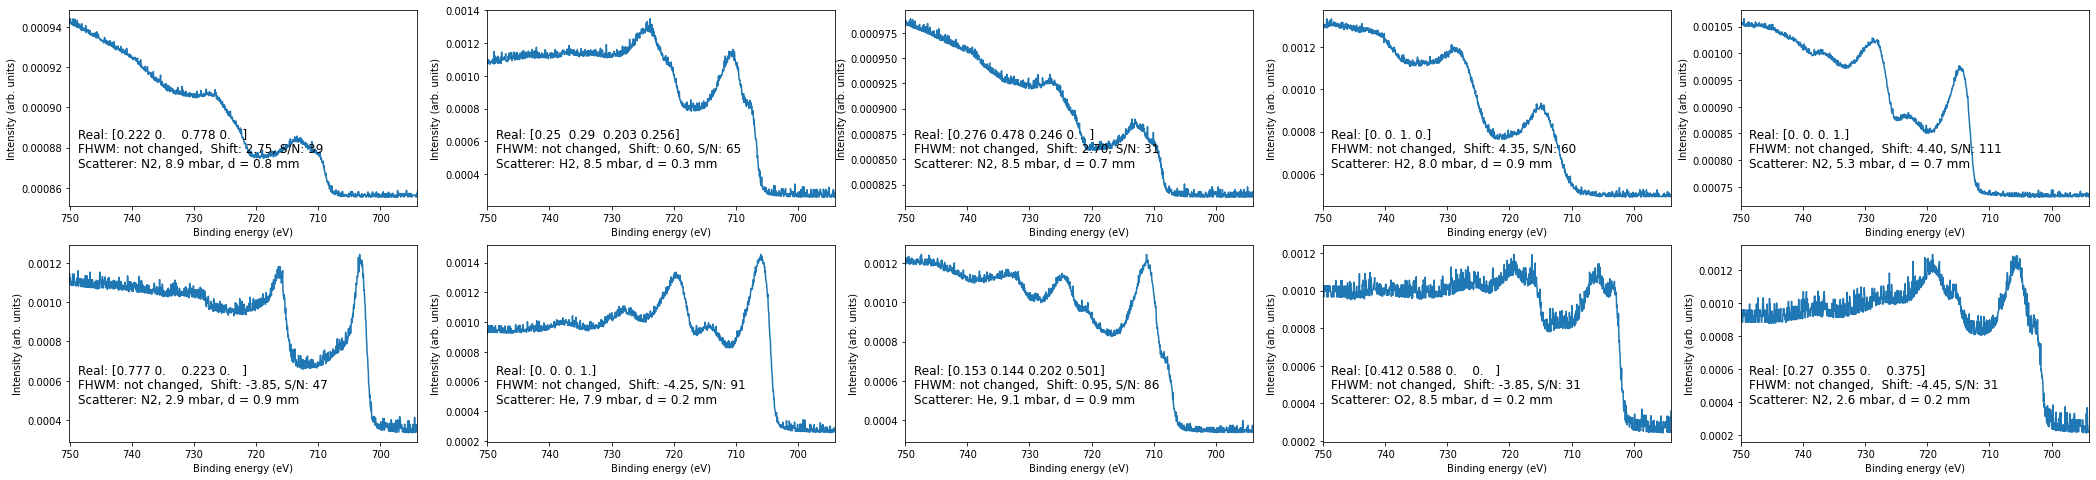

In [6]:
input_filepath = r'/content/drive/My Drive/app/datasets/20200902_iron_Mark_variable_linear_combination_gas_phase_100000.h5'
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 1000 #99999

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
               
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Design the model

In [7]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

Models module was loaded.


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Lambda
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.python.keras import backend as K

class CustomCNNTalos(models.EmptyModel):
    def __init__(self, inputshape, num_classes, params):      
        input_1 = Input(shape = inputshape)
                
        conv_1_short = Conv1D(
            params['conv_1_short_filters'],
            params['conv_1_short_kernel_size'],
            padding = 'same',
            activation = params['conv_1_short_activation'])(input_1)
        conv_1_medium = Conv1D(
            params['conv_1_medium_filters'],
            params['conv_1_medium_kernel_size'],
            padding = 'same',
            activation = params['conv_1_medium_activation'])(input_1)
        conv_1_long = Conv1D(
            params['conv_1_long_filters'],
            params['conv_1_long_kernel_size'],
            padding = 'same',
            activation = params['conv_1_long_activation'])(input_1)
        sublayers = [conv_1_short, conv_1_medium, conv_1_long]
        merged_sublayers = concatenate(sublayers)

        conv_2 = Conv1D(
            params['conv_2_filters'],
            params['conv_2_kernel_size'],
            padding = 'same',
            activation = params['conv_2_activation'])(merged_sublayers)
        conv_3 = Conv1D(
            params['conv_3_filters'],
            params['conv_3_kernel_size'],
            padding = 'same',
            activation = params['conv_3_activation'])(conv_2)
        average_pool_1 = AveragePooling1D()(conv_3)
        flatten_1 = Flatten()(average_pool_1)
        drop_1 = Dropout(params['drop_1_rate'])(flatten_1)
        dense_1 = Dense(
            params['dense_1_units'],
            activation = params['dense_1_activation'])(drop_1)
        dense_2 = Dense(num_classes, activation = 'sigmoid')(dense_1)
        
        output = Lambda(lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
                        name = 'normalization')(dense_2)

        no_of_inputs = len(sublayers)

        super(CustomCNNTalos, self).__init__(inputs = input_1,
                                             outputs = output,
                                             inputshape = inputshape,
                                             num_classes = num_classes,
                                             no_of_inputs = no_of_inputs,
                                             name = 'Custom_CNN_Talos')

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

init_params = {'conv_1_short_filters' : 12,
               'conv_1_short_kernel_size' : 5,
               'conv_1_short_activation' : 'relu',
               'conv_1_medium_filters' : 12,
               'conv_1_medium_kernel_size' : 10,
               'conv_1_medium_activation' : 'relu',
               'conv_1_long_filters' : 12,
               'conv_1_long_kernel_size' : 15,
               'conv_1_long_activation' : 'relu',
               'conv_2_filters' : 10,
               'conv_2_kernel_size' : 5,
               'conv_2_activation' : 'relu',
               'conv_3_filters' : 10,
               'conv_3_kernel_size' : 5,
               'conv_3_activation' : 'relu',
               'drop_1_rate' : 0.2,
               'dense_1_units' : 4000,
               'dense_1_activation' : 'relu',
               'optimizer' : Adam,
               'learning_rate': 1e-05,
               'loss' : MeanAbsoluteError
              }

clf.model = CustomCNNTalos(clf.input_shape, clf.num_classes, init_params)
clf.model.compile(loss = init_params['loss'](),
                  optimizer = init_params['optimizer'](init_params['learning_rate']))
clf.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "Custom_CNN_Talos"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1121, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1121, 12)     72          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1121, 12)     132         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1121, 12)     192        

In [ ]:
# =============================================================================
# opt_params = {'conv_1_short_filters' : [6, 12, 18],
#               'conv_1_short_kernel_size' : [5],
#               'conv_1_short_activation' : ['relu'],
#               'conv_1_medium_filters' : [6, 12, 18],
#               'conv_1_medium_kernel_size' : [10],
#               'conv_1_medium_activation' : ['relu'],
#               'conv_1_long_filters' : [6, 12, 18],
#               'conv_1_long_kernel_size' : [15],
#               'conv_1_long_activation' : ['relu'],
#               'conv_2_filters' : [5, 10, 15],
#               'conv_2_kernel_size' : [5],
#               'conv_2_activation' : ['relu'],
#               'conv_3_filters' : [5, 10, 15],
#               'conv_3_kernel_size' : [5],
#               'conv_3_activation' : ['relu'],
#               'drop_1_rate' : [0.2],
#               'dense_1_units' : [4000],
#               'dense_1_activation' : ['relu'],
#               'optimizer' : [Adam],
#               'learning_rate': [1e-05],
#               'loss' : [MeanAbsoluteError],
#               'epochs' : [2],
#               'batch_size' : [32]
#                }
# =============================================================================

In [10]:
class Hyperoptimization():
    def __init__(self, clf):
        self.time = time
        self.data_name = data_name
        
        self.clf = clf
        self.figures = []

        root_dir = os.getcwd()
        self.dir_name = self.time + '_' + self.data_name 
        self.test_dir = os.path.join(*[root_dir, self.dir_name])
        self.csv_path = os.path.join(self.test_dir, 'test_log.csv')

        if os.path.isdir(self.test_dir) == False:
            os.makedirs(self.test_dir)
            if os.path.isdir(self.test_dir) == True:
                print('Test folder created at ' +\
                      str(self.test_dir.split(root_dir)[1]))
        else:
            print('Test folder was already at ' +\
                  str(self.test_dir.split(root_dir)[1]))
        

    def hyper_opt(self,  x_train, y_train, x_val, y_val, params):
        model_class = type(clf.model)
        model = model_class(clf.input_shape, clf.num_classes, params)
        model.compile(loss = params['loss'](),
                      optimizer = params['optimizer'](params['learning_rate']))

        out = model.fit(x = x_train,
                            y = y_train,
                            validation_data = (x_val, y_val),
                            epochs = params['epochs'],
                            callbacks=[talos.utils.live()],
                            batch_size = params['batch_size'],
                            verbose=0)
    
        return out, model

    def scan_parameter_space(self, params, **kwargs):
        X_train_data = []
        X_val_data = []
        for i in range(self.clf.model.no_of_inputs):
            X_train_data.append(clf.X_train)
            X_val_data.append(clf.X_val)

        self.scan = talos.Scan(x = X_train_data,
                               y = self.clf.y_train,
                               params = params,
                               model = self.hyper_opt,
                               experiment_name = self.dir_name,
                               x_val = X_val_data,
                               y_val = self.clf.y_val,
                               val_split = 0,
                               **kwargs)
        print('\n Parameter space was scanned!')
        self._change_csv_name()
    
    def _change_csv_name(self):
        filename = next(os.walk(self.test_dir))[2][0]
        os.rename(os.path.join(self.test_dir, filename), self.csv_path)

    def generate_analysis(self, 'hist' = True, 'corr' = True):
        self.analyzer = Analysis(self.data)
        self.clf.model = self.analyzer.load_model()

        if 'corr' == True:
           self.analyzer.correlate()

        if 'hist' == True:
           self.analyzer.histogram()

    def create_selected_plot(self, include = ['hist', 'corr']):
        if 'hist' in include :
            hist = Hist(analysis.hist)
        if 'corr' in include :
            hist = CorrPlot(analysis.hist)

    def plot_figures():
        for figure in self.figures:
            figure.plot()      


In [ ]:
class Analysis():
    def __init__(self, df):
        self.df = df

    def load_best_model(self):
        best_round, best_params = get_best_params()
        model = CustomCNNTalos(self.opt.clf.input_shape,clf.num_classes, best_params)
        model._name = 'Best_Model'
        model.set_weights(self.opt.scan.saved_weights[best_round])

        return model
    
    def get_best_params(metric):
        best_round = self.rounds2high(metric)
        best_params = dict(df.iloc[best_round])
  
        return best_round, best_params

    def _rounds2high(self, metric):
        return self.df[self.df[metric] == self.df[metric].max()].index[0]

    def _exclude_unchanged(self):
        """
        Exlude the parameters that were not changed during the Talos Scan.
        """
        exclude = []
        for key, values in df.iteritems():
            if values.nunique() == 1:
                exclude.append(key)

        return exclude

    def correlate(self, exclude):
        pass

    def hist(self, exclude):
        
import astetik as ast

class Plot():
    def __init__(self, data):
        self.data = data
        self.fig, self.ax = plt.subplots()

    def plot(self):
        pass
        

class LinePlot(Plot):
    def __init__(self, data):
        super(LinePlot, self).__init__(data)
        self.data = data

    def plot(self, bins = 10):   
        return ast.line(self.data, metric)
    
class HistPlot(Plot):
    def __init__(self, data):
        super(HistPlot, self).__init__(data)
    
    def plot(self, bins = 10):
        return ast.hist(self.data, bins=bins)
        
class CorrPot():
    def __init(self, corr):
        super(Hist, self).__init__(data)
    
    def plot(self)
        cols = self._cols(metric, exclude)
        return ast.corr(self.data[cols], color_grades=color_grades)     

In [11]:
os.chdir('/content/drive/My Drive/app/param_tests')
optim = Hyperoptimization(clf)

Test folder created at /20200908_14h21m_Fe_multiple_4_classes_variable_linear_comb_Mark_gas_phase


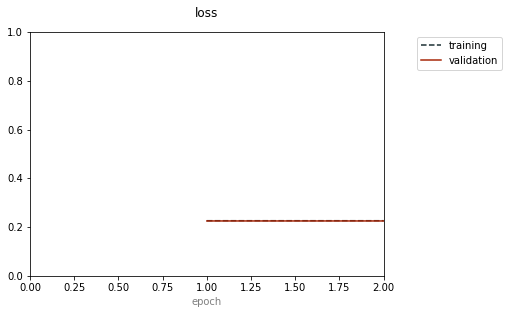

100%|██████████| 2/2 [00:19<00:00,  9.74s/it]


 Parameter space was scanned!


In [12]:
opt_params = {'conv_1_short_filters' : [6,7],
              'conv_1_short_kernel_size' : [5],
              'conv_1_short_activation' : ['relu'],
              'conv_1_medium_filters' : [6],
              'conv_1_medium_kernel_size' : [10],
              'conv_1_medium_activation' : ['relu'],
              'conv_1_long_filters' : [6],
              'conv_1_long_kernel_size' : [15],
              'conv_1_long_activation' : ['relu'],
              'conv_2_filters' : [5],
              'conv_2_kernel_size' : [5],
              'conv_2_activation' : ['relu'],
              'conv_3_filters' : [5],
              'conv_3_kernel_size' : [5],
              'conv_3_activation' : ['relu'],
              'drop_1_rate' : [0.2],
              'dense_1_units' : [4000],
              'dense_1_activation' : ['relu'],
              'optimizer' : [Adam],
              'learning_rate': [1e-05],
              'loss' : [MeanAbsoluteError],
              'epochs' : [1,2],
              'batch_size' : [32]
             }
optim.scan_parameter_space(opt_params, fraction_limit = 0.5)  

In [13]:
# use Scan object as input
analyze_object = talos.Analyze(optim.scan)
# access the dataframe with the results

# get the number of rounds in the Scan
no_of_rounds = analyze_object.rounds()

In [ ]:
# get the highest result for any metric
max_loss = analyze_object.high('val_loss')
print(f'Max loss: ' + '{:.2f}'.format(max_loss))
      
# get the round with the best result
best_round = analyze_object.rounds2high('val_loss')
print(f'Best round: ' + str(best_round))
# get the best paramaters
best_params = analyze_object.best_params('val_loss', ['loss', 'val_loss'])

# get correlation for hyperparameters against a metric
corr = analyze_object.correlate('val_loss', ['loss', 'val_loss'])

In [ ]:
# line plot
analyze_object.plot_line('val_loss')

# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_loss')

# a simple histogram
analyze_object.plot_hist('val_loss', bins=50)

# heatmap correlation
analyze_object.plot_corr('val_loss', ['loss', 'val_loss'])

# a four dimensional bar grid
analyze_object.plot_bars('epochs', 'conv_1_short_filters', 'val_loss','val_loss')

In [ ]:
p = talos.Predict(optim.scan)

# returns model_id for best performing model
p.best_model(metric='val_fmeasure')

# returns predictions for input x
p.predict(x)

# performs a 10-fold cross-validation for multi-class prediction
optim.report.evaluate(x, y, folds=10, average='macro')

## Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/app/xpsdeeplearning/train_multiple.ipynb'
output_file = os.path.join(clf.log_dir,'train_multiple_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')